In [2]:
import pydicom as dicom
import cv2   
import glob
from tqdm import tqdm
from torchvision import transforms, utils
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice 
from tifffile import imsave
from scipy import ndimage

In [14]:
def normalize(img, pxrange=(0,8000)):
    img = np.clip(img, pxrange[0], pxrange[1])
    img = np.divide(img, pxrange[1]-pxrange[0])
    img = img*255
    return img.astype(np.uint8) #return image in uint8 format for max memory

def FFT_gaussian(image, kernel = 500):
    #apply large kernel blur in frequency space
    input_ = np.fft.fft2(image)
    result = ndimage.fourier_gaussian(input_, sigma=kernel)
    result = np.fft.ifft2(result)
    return result.real

def mass_center(image):
    return np.unravel_index(np.argmax(image, axis=None), image.shape)

def crop(img, crop_size=(2048,2048)):
    cm_x, cm_y = mass_center(FFT_gaussian(img))
    
    def correct_overlap(imlen=None, croplen=None, center=None):
        assert croplen<imlen
        assert center>0 and center<imlen
        if min(imlen-center-croplen/2,center-croplen/2) >= 0:
            return center
        if imlen-center-croplen/2 < center-croplen/2:
            return imlen-croplen/2
        else:
            return croplen/2
    
    cm_x = correct_overlap(img.shape[0], crop_size[0], cm_x)
    cm_y = correct_overlap(img.shape[1], crop_size[1], cm_y)
    
    return img[int(cm_x-crop_size[0]/2):int(cm_x+crop_size[0]/2) , int(cm_y-crop_size[1]/2):int(cm_y+crop_size[1]/2)] #either return the cropped image
#     return int(cm_x-crop_size[0]/2), int(cm_x+crop_size[0]/2), int(cm_y-crop_size[1]/2), int(cm_y+crop_size[1]/2)  #or return the crop paramters (necessary for 3D)

def save_to_tiff(impath, do_norm=True, do_crop=(1024,1024),savepath = None):
    img = dicom.dcmread(impath).pixel_array
    if savepath is None:
        savepath = impath.replace('.DCM', '.tif')
    if do_norm:
        img = normalize(img)
    if do_crop is not None:
        img = crop(img)
    imsave(savepath,img)
    print(savepath)

In [15]:
import multiprocessing as mp
images_path = '../../../../datasets/femurDCMs/*/*.DCM'

with Pool(16) as pool:
    pool.map(save_to_tiff, glob.glob(images_path))

../../../../datasets/femurDCMs/0061119-06/C0000382_02588.tif
../../../../datasets/femurDCMs/0061119-06/C0000382_03368.tif
../../../../datasets/femurDCMs/0061119-06/C0000382_02595.tif
../../../../datasets/femurDCMs/0061119-06/C0000382_01298.tif
../../../../datasets/femurDCMs/0061119-06/C0000382_01070.tif
../../../../datasets/femurDCMs/0069000_07/C0000421_00369.tif
../../../../datasets/femurDCMs/0069000_07/C0000421_02819.tif
../../../../datasets/femurDCMs/0069000_07/C0000421_01529.tif
../../../../datasets/femurDCMs/0069000_07/C0000421_01179.tif
../../../../datasets/femurDCMs/0061119-06/C0000382_02164.tif
../../../../datasets/femurDCMs/0061119-06/C0000382_00855.tif
../../../../datasets/femurDCMs/0058708-01/C0000481_01861.tif
../../../../datasets/femurDCMs/0061119-06/C0000382_02750.tif
../../../../datasets/femurDCMs/0069000_07/C0000421_01484.tif
../../../../datasets/femurDCMs/0061119-06/C0000382_02730.tif
../../../../datasets/femurDCMs/0069000_07/C0000421_03027.tif
../../../../datasets/fem

KeyboardInterrupt: 

In [10]:
from multiprocessing import Pool

def f(x,y=2):
    return x*y

with Pool(2) as p:
    print(p.map(f, range(10)))

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [4]:
# specify your image path
images_path = '../../../../datasets/femurDCMs/*/*.DCM'

imlist = []
max_px = 0
min_px = 0
for i,impath in tqdm(enumerate(glob.glob(images_path))):
    if i>=10000:
        break
    if i%50 != 0:
        continue
#     print(impath)
    
    imlist.append((dicom.dcmread(impath).pixel_array,int(impath[54:-4]),impath[34:]))
#     max_px = max(np.max(dicom.dcmread(impath).pixel_array),max_px)
#     min_px = min(np.min(dicom.dcmread(impath).pixel_array),min_px)
    
#     image_format = '.png' # or '.jpg'
#     impath = impath.replace('.DCM', image_format)
#     cv2.imwrite(impath, pixel_array_numpy)
imlist = imlist
print('done')

10000it [00:01, 5335.74it/s]

done


In [11]:
def plot_histogram(imlist, ax=None):
    pixels = np.concatenate([a[0].flatten() for a in imlist],0)
    if ax is not None:
        ax.hist(pixels, 300, range=(-3000, 7000))
        return ax
    else:
        plt.hist(pixels, 300, range=(-2000, 7000))
        plt.savefig('histoplot', format = "png")

# specify your image path
images_path = '../../../../datasets/femurDCMs/*/*.DCM'

bones_path = '../../../../datasets/femurDCMs/*/'


imlist = []
for i,bone_path in tqdm(enumerate(glob.glob(bones_path))):
    bonelist = []
    for j, impath in enumerate(glob.glob(bone_path+"*.DCM")):
        if j%1000 != 0:
            continue
        bonelist.append((dicom.dcmread(impath).pixel_array,int(impath[54:-4]),impath[34:]))
    imlist.append((bonelist, bone_path))
print('done')

    


10it [00:00, 25.90it/s]

done


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


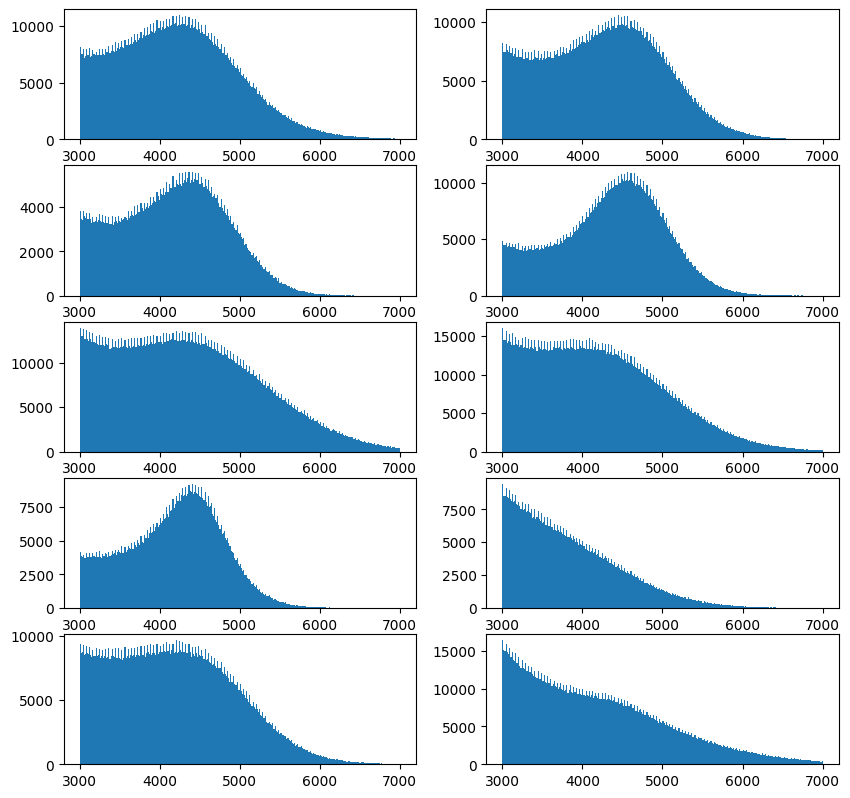

In [10]:
# Create main figure
fig = plt.figure(1, figsize=(10, 10), dpi=100)

for k in tqdm(range(10)):
    ax = fig.add_subplot(5, 2, k+1)
#     ax.set_title(imlist[k][1][20:], loc='right')
    plot_histogram(imlist[k][0], ax)
plt.savefig("pixel_intensity_histograms_3000min.png", format = 'png', facecolor = 'w')

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


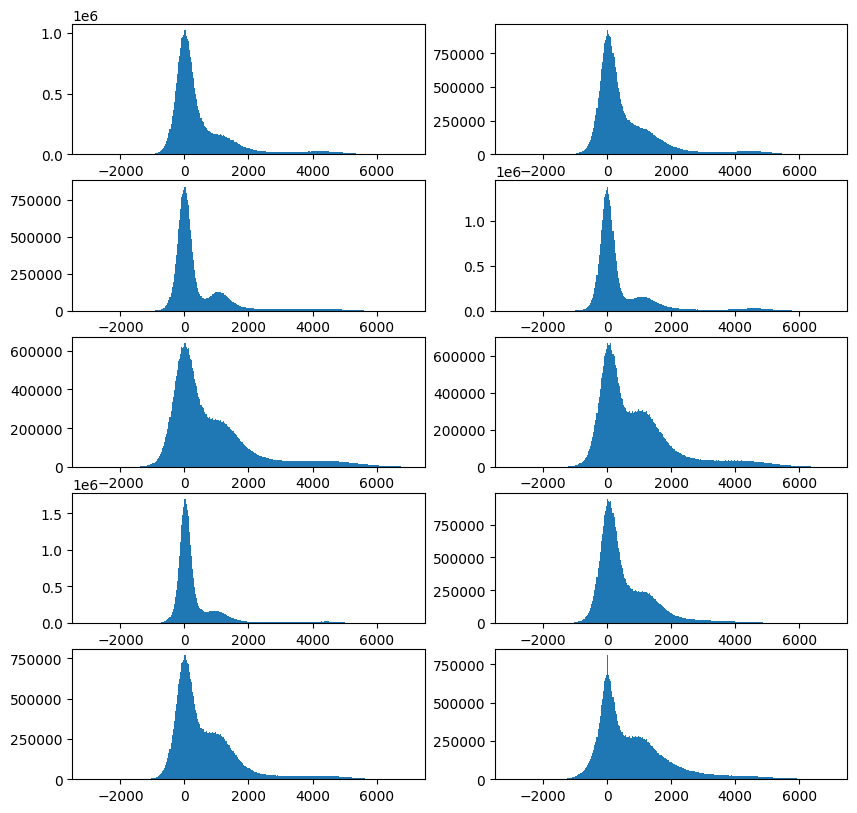

In [12]:
# Create main figure
fig = plt.figure(1, figsize=(10, 10), dpi=100)

for k in tqdm(range(10)):
    ax = fig.add_subplot(5, 2, k+1)
#     ax.set_title(imlist[k][1][20:], loc='right')
    plot_histogram(imlist[k][0], ax)
plt.savefig("pixel_intensity_histograms_3000min.png", format = 'png', facecolor = 'w')

In [21]:
plt.imshow(np.concatenate([np.concatenate([im[0] for im in islice(imlist,8)],axis=1) 
                           for i in range(4)],axis=0))

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


AxisError: axis 1 is out of bounds for array of dimension 1